## Combining data for three weeks, and splitting it into 1 minute intervals

In [97]:
import os
import pandas as pd

folder_path = "CRWV"  # or your path
all_dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath)
        df['ts_event'] = pd.to_datetime(df['ts_event'], format='mixed')  # ← FIXED
        all_dfs.append(df)

# Combine all into one big DataFrame
combined_df = pd.concat(all_dfs, ignore_index=True).sort_values("ts_event")
required_columns = [f'{side}_px_0{i}' for side in ['ask', 'bid'] for i in range(10)] + \
                   [f'{side}_sz_0{i}' for side in ['ask', 'bid'] for i in range(10)]

combined_df = combined_df.dropna(subset=required_columns)
combined_df = combined_df.set_index('ts_event')
df_1min_all = combined_df.resample('1min').first().dropna()


## Slippage function calculation

In [98]:
def calculate_slippage(snapshot, order_sizes):
    ask_prices = np.array([snapshot[f'ask_px_0{i}'] for i in range(10)])
    ask_sizes = np.array([snapshot[f'ask_sz_0{i}'] for i in range(10)])
    bid_prices = np.array([snapshot[f'bid_px_0{i}'] for i in range(10)])
    mid_price = (ask_prices[0] + bid_prices[0]) / 2

    slippage = []
    for size in order_sizes:
        remaining = size
        total_cost = 0
        for px, sz in zip(ask_prices, ask_sizes):
            if remaining <= 0:
                break
            trade_size = min(remaining, sz)
            total_cost += trade_size * px
            remaining -= trade_size
        if remaining > 0:
            slippage.append(np.nan)  # Not enough liquidity
        else:
            vwap = total_cost / size
            slippage.append(vwap - mid_price)
    return np.array(slippage)

# We are discretely calculating at each additional 10 order sizes
order_sizes = np.arange(10, 2000, 10) 


slippage_data = []

for i in range(len(df_1min_all)):
    snapshot = df_1min_all.iloc[i]
    slippage = calculate_slippage(snapshot, order_sizes)
    slippage_data.append(slippage)

# Store in DataFrame
slippage_df = pd.DataFrame(slippage_data, columns=order_sizes, index=df_1min_all.index)


## Plotting 10 random slippage vs order size to get an idea of the shape

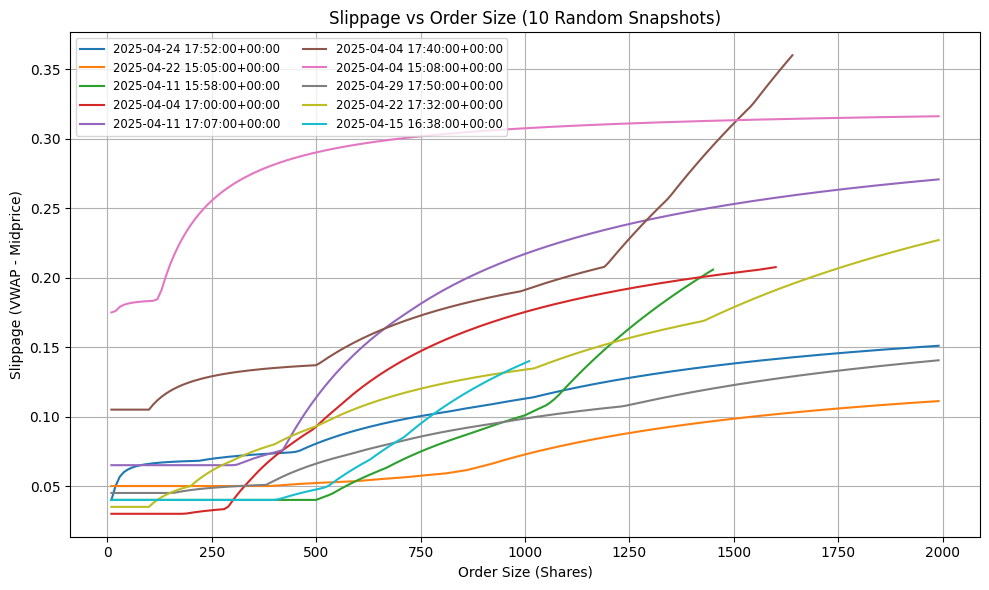

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Sampling 10 random rows from slippage_df to get a sense of what the slippage curves look like
sampled_rows = slippage_df.sample(n=10)

# Plot
plt.figure(figsize=(10, 6))
for idx, row in sampled_rows.iterrows():
    mask = ~row.isna()
    order_sizes = row.index[mask].astype(int)
    slippage_values = row[mask].values
    plt.plot(order_sizes, slippage_values, label=str(idx))

plt.xlabel('Order Size (Shares)')
plt.ylabel('Slippage (VWAP - Midprice)')
plt.title('Slippage vs Order Size (10 Random Snapshots)')
plt.grid(True)
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


In [102]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# === Models ===
def log_model(x, a, b):
    return a * np.log(x) + b

def sqrt_model(x, a, b):
    return a * np.sqrt(x) + b

def relu_log_model(x, a, b):
    return np.maximum(0, a * np.log(x) + b)

def sigmoid_model(x, L, k, x0):
    z = np.clip(k * (x - x0), -500, 500)
    return L / (1 + np.exp(-z))

def power_model(x, a, alpha,b):
    return a * x**alpha + b

# === Slippage calculation ===
def calculate_slippage(snapshot, order_sizes):
    ask_px = np.array([snapshot[f'ask_px_0{i}'] for i in range(10)])
    ask_sz = np.array([snapshot[f'ask_sz_0{i}'] for i in range(10)])
    bid_px = np.array([snapshot[f'bid_px_0{i}'] for i in range(10)])
    mid_px = (ask_px[0] + bid_px[0]) / 2

    slippage = []
    for size in order_sizes:
        remaining = size
        cost = 0
        for px, sz in zip(ask_px, ask_sz):
            if remaining <= 0:
                break
            trade = min(remaining, sz)
            cost += trade * px
            remaining -= trade
        if remaining > 0:
            slippage.append(np.nan)
        else:
            vwap = cost / size
            slippage.append(vwap - mid_px)
    return np.array(slippage)

# === Storage ===
rmse_linear, rmse_log, rmse_sqrt = [], [], []
rmse_relu_log, rmse_sigmoid, rmse_power = [], [], []

order_sizes = np.arange(10, 2000, 10)

# === Fit models and compute RMSE ===
for _, row in df_1min.iterrows():
    slip = calculate_slippage(row, order_sizes)
    mask = ~np.isnan(slip)
    x = order_sizes[mask]
    y = slip[mask]

    if len(x) < 4:
        rmse_linear.append(np.nan)
        rmse_log.append(np.nan)
        rmse_sqrt.append(np.nan)
        rmse_relu_log.append(np.nan)
        rmse_sigmoid.append(np.nan)
        rmse_power.append(np.nan)
        continue

    # Linear
    try:
        model = LinearRegression().fit(x.reshape(-1, 1), y)
        y_pred = model.predict(x.reshape(-1, 1))
        rmse_linear.append(np.sqrt(mean_squared_error(y, y_pred)))
    except:
        rmse_linear.append(np.nan)

    # Log
    try:
        popt, _ = curve_fit(log_model, x, y, maxfev=10000)
        rmse_log.append(np.sqrt(mean_squared_error(y, log_model(x, *popt))))
    except:
        rmse_log.append(np.nan)

    # Sqrt
    try:
        popt, _ = curve_fit(sqrt_model, x, y, maxfev=10000)
        rmse_sqrt.append(np.sqrt(mean_squared_error(y, sqrt_model(x, *popt))))
    except:
        rmse_sqrt.append(np.nan)

    # ReLU(log)
    try:
        popt, _ = curve_fit(relu_log_model, x, y, maxfev=10000)
        rmse_relu_log.append(np.sqrt(mean_squared_error(y, relu_log_model(x, *popt))))
    except:
        rmse_relu_log.append(np.nan)

    # Sigmoid
    try:
        popt, _ = curve_fit(sigmoid_model, x, y, maxfev=10000, p0=(max(y), 0.01, 500))
        rmse_sigmoid.append(np.sqrt(mean_squared_error(y, sigmoid_model(x, *popt))))
    except:
        rmse_sigmoid.append(np.nan)

    # Power (convex)
    try:
        popt, _ = curve_fit(
            power_model, x, y,
            bounds=([0, 1.0, -np.inf], [np.inf, 3.0, np.inf]),
            maxfev=10000
        )
        y_pred = power_model(x, *popt)
        rmse_power.append(np.sqrt(mean_squared_error(y, y_pred)))
    except:
        rmse_power.append(np.nan)

# === Result Table ===
average_rmse = {
    "linear": np.nanmean(rmse_linear),
    "log": np.nanmean(rmse_log),
    "sqrt": np.nanmean(rmse_sqrt),
    "relu_log": np.nanmean(rmse_relu_log),
    "sigmoid": np.nanmean(rmse_sigmoid),
    "power": np.nanmean(rmse_power),
}

rmse_table = pd.DataFrame.from_dict(average_rmse, orient="index", columns=["Average RMSE"])
print(rmse_table)


          Average RMSE
linear        0.015822
log           0.026517
sqrt          0.017302
relu_log      0.017590
sigmoid       0.008150
power         0.013171


## Sigmoid does better than the others. We plot an example of a fit

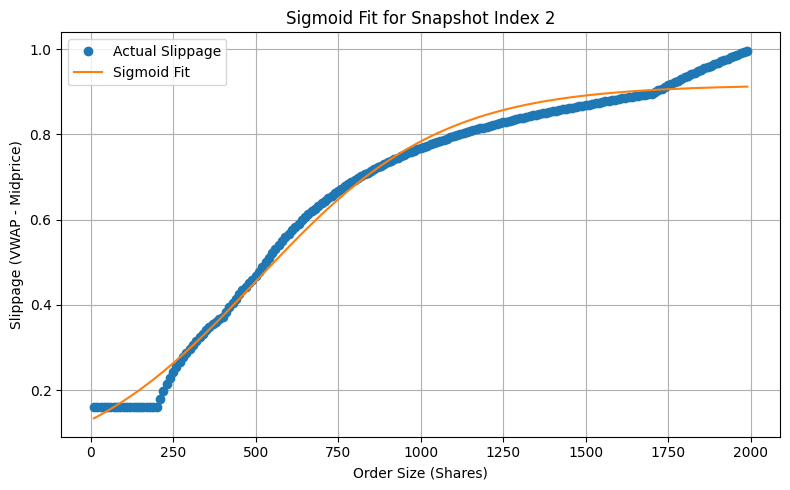

In [106]:
# Choose the snapshot index you want to visualize
i = 2  # ← change this to any valid index in df_1min
row = df_1min.iloc[i]

# Calculate slippage
order_sizes = np.arange(10, 2000, 10)
slippage = calculate_slippage(row, order_sizes)

# Filter out NaNs
mask = ~np.isnan(slippage)
x = order_sizes[mask]
y = slippage[mask]

# Fit sigmoid and plot
if len(x) >= 4:
    try:
        popt, _ = curve_fit(sigmoid_model, x, y, maxfev=10000, p0=(max(y), 0.01, 500))
        y_pred = sigmoid_model(x, *popt)

        # Plot
        plt.figure(figsize=(8, 5))
        plt.plot(x, y, 'o', label='Actual Slippage')
        plt.plot(x, y_pred, '-', label='Sigmoid Fit')
        plt.xlabel('Order Size (Shares)')
        plt.ylabel('Slippage (VWAP - Midprice)')
        plt.title(f'Sigmoid Fit for Snapshot Index {i}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except:
        print(f"Curve fit failed for snapshot index {i}.")
else:
    print(f"Not enough valid points to fit for snapshot index {i}.")
